## 1. Load and Inspect Data

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

In [7]:
# Load dataset
df = pd.read_csv("data/cf_dataset.csv")
print(f"Loaded dataset with {len(df):,} rows")
df.head()

Loaded dataset with 18,942,152 rows


,user_id,game_id,rating
0,Tonydorrf,213788,8.0
1,tachyon14k,213788,8.0
2,Ungotter,213788,8.0
3,brainlocki3,213788,8.0
4,PPMP,213788,8.0


## 2. Explore Rating and User Distribution

In [8]:
# --- Basic EDA ---
print("Unique users:", df['user_id'].nunique())
print("Unique games:", df['game_id'].nunique())
print("Average rating:", df['rating'].mean().round(2))

Unique users: 411374
Unique games: 21925
Average rating: 7.13


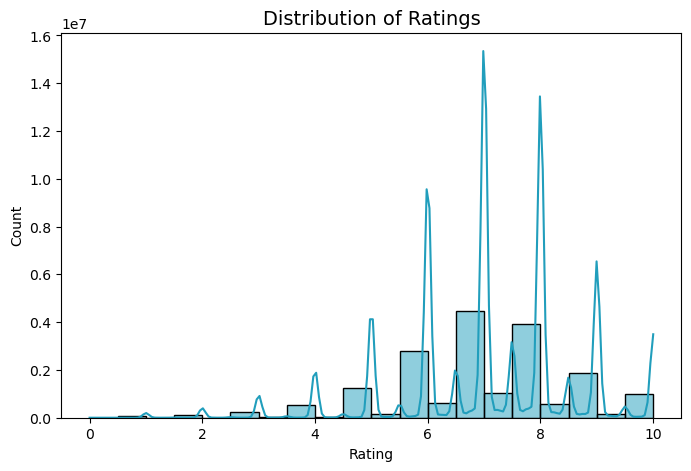

In [14]:
# --- Rating Distribution ---
plt.figure(figsize=(8,5))
sns.histplot(df['rating'], bins=20, kde=True, color="#219EBC")
plt.title("Distribution of Ratings", fontsize=14)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

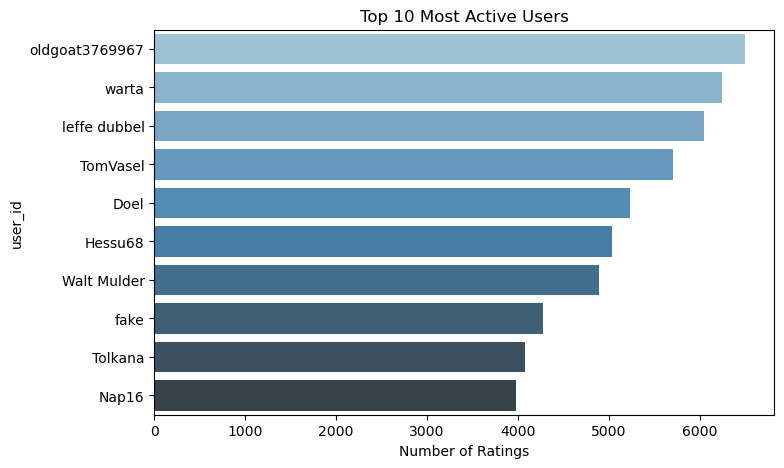

In [25]:
# --- Most Active Users ---
user_activity = df['user_id'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=user_activity.values, y=user_activity.index, hue=user_activity.index, palette="Blues_d")
plt.title("Top 10 Most Active Users")
plt.xlabel("Number of Ratings")
plt.show()

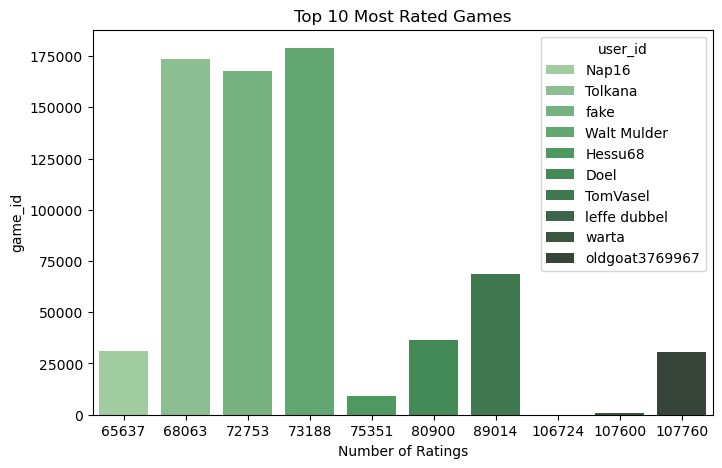

In [27]:
# --- Most Rated Games ---
game_popularity = df['game_id'].value_counts().head(10)
plt.figure(figsize=(8,5))
sns.barplot(x=game_popularity.values, y=game_popularity.index, hue=user_activity.index, palette="Greens_d")
plt.title("Top 10 Most Rated Games")
plt.xlabel("Number of Ratings")
plt.show()

## 3. Build User-Item Rating Matrix

In [20]:
# (Use a small sample for performance)
sample_users = df['user_id'].unique()[:5000]
sample = df[df['user_id'].isin(sample_users)]
user_item_matrix = sample.pivot_table(index='user_id', columns='game_id', values='rating')
print(f"User-Item matrix shape: {user_item_matrix.shape}")

user_item_matrix.head(3)

User-Item matrix shape: (5000, 21851)


game_id,1,2,3,4,5,6,7,8,9,10,...,345584,345976,346482,346501,346703,346965,347146,347521,348955,349131
user_id,,,,,,,,,,,,,,,,,,,,,
-Johnny-,5.0,NaN,4.0,NaN,7.0,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
015599m,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
07cbdj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# --- Fill missing values with 0 for similarity calculation ---
user_item_filled = user_item_matrix.fillna(0)

## 4. Compute User Similarity Matrix -

In [35]:
user_similarity = cosine_similarity(user_item_filled)
user_similarity_df = pd.DataFrame(user_similarity, index=user_item_filled.index, columns=user_item_filled.index)
print("Computed user-user cosine similarity matrix.")
user_similarity_df.head()

Computed user-user cosine similarity matrix.


user_id,-Johnny-,015599m,07cbdj,1 Family Meeple,143245,2015Redsti,221boardgames,2manygames,33cb,3villans,...,zizishaoye,zkaufman,zmoneaux,zolle001,zombiekipper,zoobrr,zx883,zydoz,zzhou,zzzabiss
user_id,,,,,,,,,,,,,,,,,,,,,
-Johnny-,1.000000,0.173794,0.085344,0.163580,0.102553,0.044949,0.138136,0.069256,0.099260,0.017783,...,0.237485,0.076432,0.050069,0.080560,0.018652,0.095631,0.074414,0.302427,0.125269,0.153940
015599m,0.173794,1.000000,0.076590,0.150440,0.094759,0.092147,0.150010,0.053817,0.091166,0.062976,...,0.120658,0.125676,0.033212,0.031782,0.096108,0.084487,0.084565,0.116946,0.176611,0.134729
07cbdj,0.085344,0.076590,1.000000,0.039777,0.067922,0.020201,0.012084,0.066084,0.046166,0.000000,...,0.056879,0.013972,0.033849,0.142724,0.000000,0.084422,0.036168,0.098932,0.020088,0.061646
1 Family Meeple,0.163580,0.150440,0.039777,1.000000,0.157207,0.164308,0.265981,0.037916,0.393661,0.067343,...,0.346721,0.169514,0.091229,0.075777,0.084051,0.153405,0.082090,0.199142,0.224160,0.331653
143245,0.102553,0.094759,0.067922,0.157207,1.000000,0.030998,0.067924,0.038084,0.150223,0.044886,...,0.147501,0.091143,0.094568,0.113735,0.013572,0.108965,0.047089,0.117407,0.075615,0.122791


In [37]:
# --- Example: Find top similar users for a given user ---
target_user = user_item_filled.index[0]
top_similar_users = user_similarity_df[target_user].sort_values(ascending=False)[1:6]
print(f"Top similar users to '{target_user}':")
print(top_similar_users)

Top similar users to '-Johnny-':
user_id
Shakar      0.408736
Citadel     0.392481
sourwyrm    0.380594
ccomeaux    0.362728
jjhalko     0.360729
Name: -Johnny-, dtype: float64


## 5. User-based CF: Recommend Games

In [43]:
def recommend_games_user_cf(user_id, user_item_matrix, similarity_df, top_n=5):
    if user_id not in user_item_matrix.index:
        print("User not found.")
        return []
    
    similar_users = similarity_df[user_id].sort_values(ascending=False)[1:6]
    similar_users_ratings = user_item_matrix.loc[similar_users.index]
    
    weighted_ratings = similar_users_ratings.T.dot(similar_users)
    recommendations = weighted_ratings / similar_users.sum()
    
    user_rated = user_item_matrix.loc[user_id].dropna().index
    recommendations = recommendations.drop(user_rated, errors='ignore')
    
    return recommendations.sort_values(ascending=False).head(top_n)

In [45]:
user_recs = recommend_games_user_cf(target_user, user_item_matrix, user_similarity_df)
print(f"🎯 Recommended Games for '{target_user}':")
print(user_recs)

🎯 Recommended Games for '-Johnny-':
game_id
3201     8.290763
38453    7.995656
28143    7.761323
46       7.558463
25554    7.380763
dtype: float64


In [47]:
# --- Item-based CF (Game Similarity) ---
item_item_filled = user_item_filled.T
item_similarity = cosine_similarity(item_item_filled)
item_similarity_df = pd.DataFrame(item_similarity, index=item_item_filled.index, columns=item_item_filled.index)

In [48]:
# --- Example: Find similar games ---
target_game = item_item_filled.index[0]
top_similar_games = item_similarity_df[target_game].sort_values(ascending=False)[1:6]
print(f"Top similar games to '{target_game}':")
print(top_similar_games)

Top similar games to '1':
game_id
4098    0.562225
93      0.550723
9216    0.550002
5404    0.544973
555     0.544666
Name: 1, dtype: float64


In [ ]:
# --- Save matrices for reuse ---
user_similarity_df.to_csv("user_similarity.csv")
item_similarity_df.to_csv("item_similarity.csv")
print("Saved user and item similarity matrices.")